In [5]:
## Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpStatus
import matplotlib.pyplot as plt
import numpy as np
import time 
import os
import seaborn as sns
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

# read input data
INPUT_PATH = 'C:/Users/Kaustubh/MP-Ensystems-Demand-flexibility-model/input data/Generation module test/'

OUTPUT_PATH = 'C:/Users/Kaustubh/MP-Ensystems-Demand-flexibility-model/output/'


ppa =pd.read_excel(INPUT_PATH + 'MODCON.xlsx')
projected_demand = pd.read_csv(INPUT_PATH + 'demand3000.csv')
market_price = pd.read_excel(INPUT_PATH+'market_rate3000.xlsx')
re = pd.read_excel(INPUT_PATH +'RE3000.xlsx')
#data for load optimisation
tariff = pd.read_csv(INPUT_PATH +'tariff_10.csv')
# clustered_profile = pd.read_csv(INPUT_PATH+'cluster_profile_10.csv')
# trigger = pd.read_csv(INPUT_PATH+'trigger_10.csv')
mode=['DF','DF','DF','DF','DF','DF','DR','DR','DR','DR']
# flex = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
flex = [0.2,0.2,0.5,0.5,0.2,0.1,0.3,0.4,0.2,0.5]

In [22]:
def compute_generation_cost(demand,n=0):    
    #RE Power generation profiles
    start_time = time.time()
   

    solar_pu_cost = 0
    wind_pu_cost =0
    market_limit = 0
    
    solar=re['Solar']
    wind=re['Wind']
    RE=solar+wind

    # Net demand for conventional genration
    net_demand = demand - re.sum(axis=1)

    num_plants=len(ppa['Capacity'])
   

    
    generation_capacity = ppa['Capacity']
    technical_minimum = ppa['Technical_min']
    fixed_cost = ppa['Fixed cost']  # Fixed cost for each plant
    Variable_cost=ppa['Variable cost']
   
    battery_power_capacity = 100
    battery_energy_capacity =0
    battery_initial_state = 0 # initial state of charge

    total_daily_energy = projected_demand.iloc[:,:].sum()
    cost_matrix = pd.DataFrame()

    ramping_up = ppa['Ramping_up'] # Ramping up limit for each plant
    ramping_down = ppa['Ramping down']  # Ramping down limit for each plant
    

    num_plants=len(generation_capacity)
    num_hours=len(demand.values)
#     print(num_hours)
  
# --------------------------------------------------------------------------------

    problem = LpProblem("Power_Generation_Optimization", LpMinimize)

    # Define the decision variables
    schedule = [[LpVariable(f"Schedule_{t}_{p}") for p in range(num_plants)] 
                for t in range(num_hours)]
    market_drawl = [LpVariable(f"Market_{t}") for t in range(num_hours)]
    b_soc = [LpVariable(f"b_soc_{t}",lowBound=0, upBound = battery_energy_capacity) for t in range(num_hours+1)]
               
    

    # Set the objective function
    problem += lpSum(schedule[t][p] * Variable_cost[p] for t in range(num_hours) for p in range(num_plants))+lpSum(market_drawl[t]*market_price['rate'][t] for t in range(num_hours))
   

    # Add the constraints

    #Constraint 1  - ramping up and down constraints 1% for thermal, 3% for gas, 10% for hydro
    for t in range(num_hours - 1):
        for p in range(num_plants):
            del_schedule = schedule[t+1][p] - schedule[t][p]
            problem += ramping_down[p] <= del_schedule <= ramping_up[p]

    #Constraint 2 -  technical Minimum
    for t in range(num_hours):
        for p in range(num_plants):
            problem += schedule[t][p]>=technical_minimum[p]


    #Constraint 3 - Total generation in slot i = Total demand in slot i
    for t in range(num_hours):
        problem += lpSum(schedule[t][p] for p in range(num_plants)) ==net_demand[t]-market_drawl[t]-b_soc[t]+b_soc[t+1]
        

    #Constraint 4 - Generation should not exceed capacity
    for t in range(num_hours):
        for p in range(num_plants):
            problem += schedule[t][p] <= ppa['Capacity'][p]
            
     #constraint 5 - sales in market power should be less thanmarket limit of net demand
    for t in range(num_hours):
        problem +=market_drawl[t] <=market_limit*net_demand[t]
        problem +=market_drawl[t] >=-market_limit*net_demand[t]
        
#     #constraint 7 - battery charging and discharging constriants

    for t in range(num_hours):
        b_power = b_soc[t]-b_soc[t+1]
        problem+= -battery_power_capacity<=b_power<=battery_power_capacity
    
           
    # Solve the problem
    problem.solve()

    # Check the status of the solution
    
    print("Generation optimisation Status:", LpStatus[problem.status])  

    end_time0=time.time()
 #______________________________________________________________________________________________________   
    # saving variable values in dataframe

    schedule_gen = pd.DataFrame(index=range(num_hours), columns=range(num_plants))
    market_power = pd.DataFrame(index=range(num_hours))
    battery_profile = pd.DataFrame(index=range(num_hours))
    
   
    for t in range(num_hours):
        for p in range(num_plants):
            schedule_gen.at[t, p] = schedule[t][p].varValue
        market_power.at[t,0] = market_drawl[t].varValue
        battery_profile.at[t,0]=b_soc[t+1].varValue
        
       
    # dataframe to csv
    schedule_gen.to_csv(OUTPUT_PATH + "schedule_output_" + str(n) + ".csv", index=False)
    
    # generation cost = schedule of plant * variable_cost
    re_cost = solar*solar_pu_cost + wind*wind_pu_cost
    market_cost = market_power.iloc[:,0]*market_price.iloc[:,0]
    total_generation_cost = np.dot(np.array(schedule_gen.iloc[:,:]),np.array(Variable_cost[:])) + re_cost +market_cost
#     cost_without_RE = total_generation_cost - re_cost
    
    #per unit generation cost = total generation cost /total units
    per_unit_generation_cost = total_generation_cost/(projected_demand['demand'] - re.sum(axis=1))
    
    end_time= time.time()
    
    total_time1 = end_time0 - start_time
    total_time2 = end_time - start_time
#     print('Time taken for optimisation:',total_time1)
    print('Total time elapsed:',total_time2)

    return per_unit_generation_cost, market_power, battery_profile,net_demand

In [23]:
[pu_gen,mp,bp,net_demand]=compute_generation_cost(projected_demand['demand'])

Generation optimisation Status: Optimal
Total time elapsed: 30.662164211273193


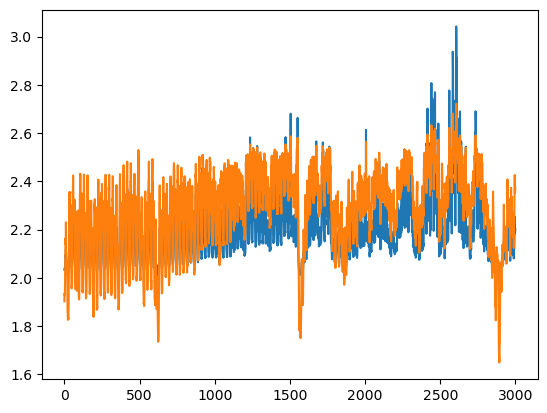

In [26]:
plt.plot(pu_gen[:])
plt.plot(net_demand[:]/10000)


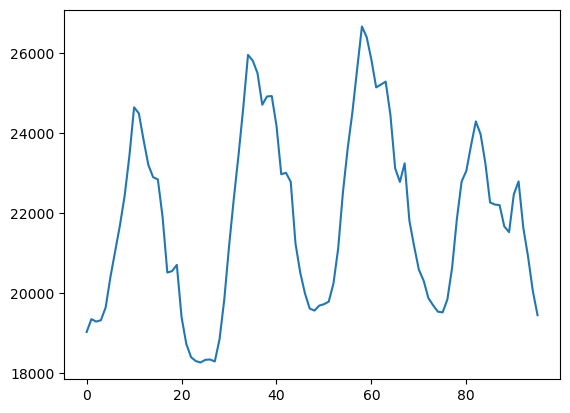

In [18]:
plt.plot(projected_demand['demand'][0:96]-)

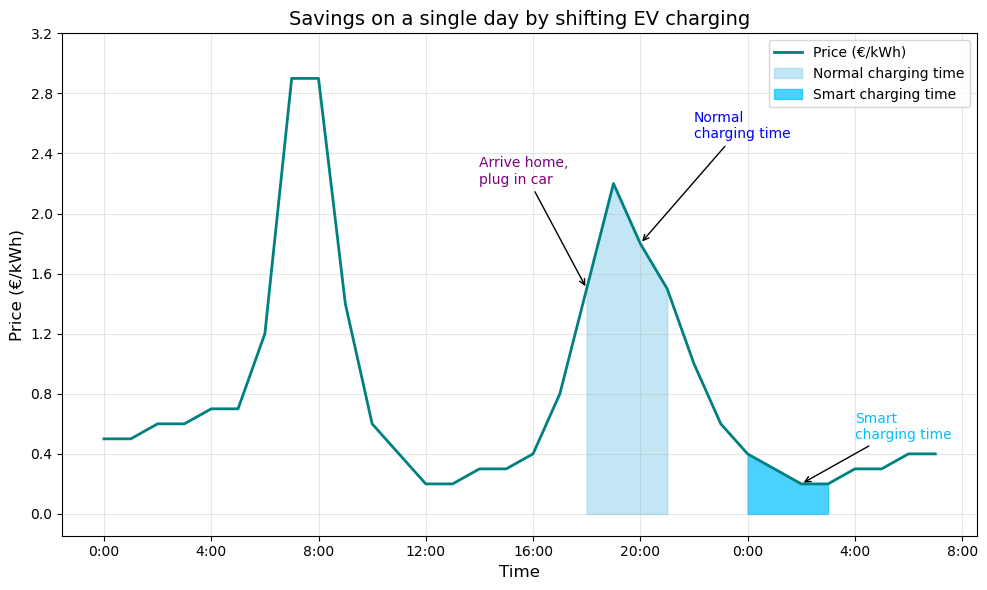

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Create sample time-series data
time = np.arange(0, 32, 1)  # 32 time points
price = [0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 1.2, 2.9, 2.9, 1.4, 0.6, 0.4, 0.2, 0.2, 0.3, 
         0.3, 0.4, 0.8, 1.5, 2.2, 1.8, 1.5, 1.0, 0.6, 0.4, 0.3, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4]

# Convert time points to human-readable format
time_labels = ['0:00', '4:00', '8:00', '12:00', '16:00', '20:00', '0:00', '4:00', '8:00']
price = np.array(price)

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot the price curve
plt.plot(time, price, color='teal', linewidth=2, label='Price (€/kWh)')

# Highlight the Normal Charging Time
plt.fill_between(time[18:22], price[18:22], 0, color='skyblue', alpha=0.5, label='Normal charging time')

# Highlight the Smart Charging Time
plt.fill_between(time[24:28], price[24:28], 0, color='deepskyblue', alpha=0.7, label='Smart charging time')

# Add annotations for key events
plt.annotate('Arrive home,\nplug in car', xy=(18, price[18]), xytext=(14, 2.2),
             arrowprops=dict(facecolor='purple', arrowstyle='->'), color='purple', fontsize=10)

plt.annotate('Normal\ncharging time', xy=(20, price[20]), xytext=(22, 2.5),
             arrowprops=dict(facecolor='blue', arrowstyle='->'), color='blue', fontsize=10)

plt.annotate('Smart\ncharging time', xy=(26, price[26]), xytext=(28, 0.5),
             arrowprops=dict(facecolor='deepskyblue', arrowstyle='->'), color='deepskyblue', fontsize=10)

# Add labels and title
plt.title("Savings on a single day by shifting EV charging", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price (€/kWh)", fontsize=12)
plt.xticks(np.linspace(0, 32, len(time_labels)), time_labels, rotation=0)
plt.yticks(np.arange(0, 3.5, 0.4))

# Add grid and legend
plt.grid(alpha=0.3)
plt.legend(loc='upper right', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()
